## THIS STUDIES DATA BEFORE CAMP_A_18 DAY 587

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LinearRegression


sns.set(color_codes = True)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

In [2]:
dir_path = 'Kroger_Retail_Dunnhumby/'

file1= dir_path + 'transaction_data.csv'
file2 = dir_path + 'hh_demographic.csv'
file3 = dir_path + 'coupon_redempt.csv'
file4= dir_path + 'coupon.csv'
file5 = dir_path + 'campaign_desc.csv'
file6 = dir_path + 'campaign_table.csv'
file7= dir_path + 'causal_data.csv'
file8 = dir_path + 'product.csv'


In [3]:
def load_data(filename):
    df = pd.read_csv(filename)
    df.columns = df.columns.str.lower()
    return df
    

In [4]:
# import data into dataframe

df_trans_full = load_data(file1)
df_cus_full = load_data(file2)
df_coupon_redempt_full = load_data(file3)
df_coupon_full = load_data(file4)
df_camp_cus_full = load_data(file6)
df_prod = load_data(file8)

df_campaign_detail = pd.read_csv('DATA_CLEAN/campaign_details.csv')
df_camp_des = df_campaign_detail

In [5]:
print('Total trans', df_trans_full.shape)
df_trans = df_trans_full[df_trans_full.day<587]
print('Total trans before day 587', df_trans.shape)

Total trans (2595732, 12)
Total trans before day 587 (2077756, 12)


In [6]:
print('Total redemption', df_coupon_redempt_full.shape)
df_coupon_redempt = df_coupon_redempt_full.query('campaign<18 or campaign>25')
print('Total redemption before day 587', df_coupon_redempt.shape)

Total redemption (2318, 4)
Total redemption before day 587 (1420, 4)


In [7]:
print('Total coupons', df_coupon_full.shape)
df_coupon = df_coupon_full.query('campaign<18 or campaign>25')
print('Total coupons before day 587', df_coupon.shape)

Total coupons (124548, 3)
Total coupons before day 587 (78221, 3)


In [8]:
print('Total camps cus records', df_camp_cus_full.shape)
df_camp_cus = df_camp_cus_full.query('campaign<18 or campaign>25')
print('Total camps cus records before day 587', df_camp_cus.shape)

Total camps cus records (7208, 3)
Total camps cus records before day 587 (4890, 3)


In [9]:
arr_cus_unique = df_trans.household_key.unique()
print('Total households',len(arr_cus_unique))

# get customers receiving campaigns before day 587 (not receiving campaigns from 18 - 25)
arr_cus_camp = df_camp_cus.household_key.unique()
print('Households received campaigns',len(arr_cus_camp))

arr_cus_no_camp = set(arr_cus_unique)-set(arr_cus_camp)
print('Households did not receive campaigns',len(arr_cus_no_camp))

arr_cus_redempt = df_coupon_redempt.household_key.unique()
print('Households redeemed coupons',len(arr_cus_redempt))

arr_cus_no_redempt = set(arr_cus_camp)-set(arr_cus_redempt)
print('Households received coupons but did not redeem',len(arr_cus_no_redempt))


Total households 2498
Households received campaigns 1460
Households did not receive campaigns 1038
Households redeemed coupons 346
Households received coupons but did not redeem 1114


In [10]:
total_coupons = df_coupon.groupby(['campaign','coupon_upc']).count().reset_index()
total_coupons = total_coupons[['campaign','coupon_upc']].groupby('campaign').count().reset_index()
total_coupons = total_coupons.rename(columns={'coupon_upc':'total_coupons'})
total_coupons.total_coupons.sum()

1079

In [11]:
df_household = pd.DataFrame(df_trans.household_key.unique())
df_household.columns = ['household_key']
df_household


,household_key
0,2375
1,1364
2,1130
3,1173
4,98
...,...
2493,338
2494,1035
2495,615
2496,1077


In [12]:
# create household table with comprehensive details

df_household['received_campaign'] = 0
df_household.loc[df_household.household_key.isin(arr_cus_camp),'received_campaign'] = 1
df_household


,household_key,received_campaign
0,2375,1
1,1364,1
2,1130,1
3,1173,0
4,98,1
...,...,...
2493,338,1
2494,1035,0
2495,615,0
2496,1077,0


In [13]:
df_household['redeemed_coupons'] = 0
df_household.loc[df_household.household_key.isin(arr_cus_redempt),'redeemed_coupons'] = 1
df_household

,household_key,received_campaign,redeemed_coupons
0,2375,1,1
1,1364,1,1
2,1130,1,0
3,1173,0,0
4,98,1,0
...,...,...,...
2493,338,1,0
2494,1035,0,0
2495,615,0,0
2496,1077,0,0


In [14]:
total_camps = df_camp_cus.groupby(['household_key']).count().reset_index()
total_camps = total_camps[['household_key','campaign']].rename(columns={'campaign':'total_campaigns_received'})
total_camps

df_household = df_household.merge(total_camps,how='left',on='household_key')
df_household.fillna(0,inplace=True)
df_household



,household_key,received_campaign,redeemed_coupons,total_campaigns_received
0,2375,1,1,1.0
1,1364,1,1,4.0
2,1130,1,0,5.0
3,1173,0,0,0.0
4,98,1,0,2.0
...,...,...,...,...
2493,338,1,0,2.0
2494,1035,0,0,0.0
2495,615,0,0,0.0
2496,1077,0,0,0.0


In [15]:
total_camp_types = df_camp_cus.groupby(['household_key','description']).count()
total_camp_types


campaign
household_key description          
1             TypeA               2
              TypeB               2
3             TypeA               2
              TypeC               1
4             TypeA               1
...                             ...
2498          TypeB               2
              TypeC               1
2499          TypeA               1
2500          TypeA               2
              TypeB               3

[2556 rows x 1 columns]

In [16]:
t = total_camp_types.unstack(level=-1)
t
t.columns = ['TypeA','TypeB','TypeC']
t.fillna(0,inplace=True)

df_household = df_household.merge(t,how='left',on='household_key')
df_household


# df_household[df_household.household_key==1]

,household_key,received_campaign,redeemed_coupons,total_campaigns_received,TypeA,TypeB,TypeC
0,2375,1,1,1.0,1.0,0.0,0.0
1,1364,1,1,4.0,3.0,1.0,0.0
2,1130,1,0,5.0,4.0,0.0,1.0
3,1173,0,0,0.0,NaN,NaN,NaN
4,98,1,0,2.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...
2493,338,1,0,2.0,2.0,0.0,0.0
2494,1035,0,0,0.0,NaN,NaN,NaN
2495,615,0,0,0.0,NaN,NaN,NaN
2496,1077,0,0,0.0,NaN,NaN,NaN


In [17]:
total_camp_engaged = df_coupon_redempt.groupby(['household_key']).campaign.count().reset_index()
df_household = df_household.merge(total_camp_engaged,how='left',on='household_key')
df_household.fillna(0,inplace=True)

df_household.rename(columns={'campaign':'total_campaigns_engaged'},inplace=True)
df_household.head()


,household_key,received_campaign,redeemed_coupons,total_campaigns_received,TypeA,TypeB,TypeC,total_campaigns_engaged
0,2375,1,1,1.0,1.0,0.0,0.0,8.0
1,1364,1,1,4.0,3.0,1.0,0.0,1.0
2,1130,1,0,5.0,4.0,0.0,1.0,0.0
3,1173,0,0,0.0,0.0,0.0,0.0,0.0
4,98,1,0,2.0,1.0,0.0,1.0,0.0


In [18]:
# Total coupons received for each household

total_coupons_received = df_camp_cus.merge(df_camp_des[['campaign','coupons_giveout']],how='left',on='campaign')
total_coupons_received = total_coupons_received.groupby('household_key').agg({'coupons_giveout':'sum'}).reset_index()
total_coupons_received

df_household = df_household.merge(total_coupons_received,how='left',on='household_key')
df_household.fillna(0,inplace=True)
df_household

df_household.rename(columns={'coupons_giveout':'total_coupons_received'},inplace=True)
df_household


,household_key,received_campaign,redeemed_coupons,total_campaigns_received,TypeA,TypeB,TypeC,total_campaigns_engaged,total_coupons_received
0,2375,1,1,1.0,1.0,0.0,0.0,8.0,16.0
1,1364,1,1,4.0,3.0,1.0,0.0,1.0,61.0
2,1130,1,0,5.0,4.0,0.0,1.0,0.0,98.0
3,1173,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,98,1,0,2.0,1.0,0.0,1.0,0.0,50.0
...,...,...,...,...,...,...,...,...,...
2493,338,1,0,2.0,2.0,0.0,0.0,0.0,32.0
2494,1035,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2495,615,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2496,1077,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Total coupons redeemed for each household

total_coupons_redempt = df_coupon_redempt.groupby(['household_key']).coupon_upc.count().reset_index()
df_household = df_household.merge(total_coupons_redempt,how='left',on='household_key')
df_household.fillna(0,inplace=True)

df_household.rename(columns={'coupon_upc':'total_coupons_redeemed'},inplace=True)
df_household.head()


,household_key,received_campaign,redeemed_coupons,total_campaigns_received,TypeA,TypeB,TypeC,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed
0,2375,1,1,1.0,1.0,0.0,0.0,8.0,16.0,8.0
1,1364,1,1,4.0,3.0,1.0,0.0,1.0,61.0,1.0
2,1130,1,0,5.0,4.0,0.0,1.0,0.0,98.0,0.0
3,1173,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,98,1,0,2.0,1.0,0.0,1.0,0.0,50.0,0.0


In [20]:
df_household['camp_conversion_rate'] = round(df_household.total_campaigns_engaged / df_household.total_campaigns_received,2)

df_household['coupon_conversion_rate'] = round(df_household.total_coupons_redeemed / df_household.total_coupons_received,2)
df_household.fillna(0,inplace=True)

df_household

,household_key,received_campaign,redeemed_coupons,total_campaigns_received,TypeA,TypeB,TypeC,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate
0,2375,1,1,1.0,1.0,0.0,0.0,8.0,16.0,8.0,8.00,0.50
1,1364,1,1,4.0,3.0,1.0,0.0,1.0,61.0,1.0,0.25,0.02
2,1130,1,0,5.0,4.0,0.0,1.0,0.0,98.0,0.0,0.00,0.00
3,1173,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
4,98,1,0,2.0,1.0,0.0,1.0,0.0,50.0,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2493,338,1,0,2.0,2.0,0.0,0.0,0.0,32.0,0.0,0.00,0.00
2494,1035,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
2495,615,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
2496,1077,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00


In [21]:
# Calculate total spend of each household for top 6 most-purchased product categories

product_category_list = ['GROCERY','DELI','PRODUCE','KIOSK-GAS','DRUG GM','NUTRITION','SALAD BAR','MEAT']

for c in product_category_list:
    # print(c)
    arr_prod_id = df_prod[df_prod.department==c]['product_id']
    
    df_total_spend = df_trans[df_trans.product_id.isin(arr_prod_id)].groupby('household_key').sales_value.sum().reset_index()
    
    new_name = c + '_spend'
    
    df_total_spend.rename(columns={'sales_value':new_name},inplace=True)
    
    df_household = df_household.merge(df_total_spend,how='left',on='household_key')


In [22]:
df_household.fillna(0,inplace=True)
df_household

,household_key,received_campaign,redeemed_coupons,total_campaigns_received,TypeA,TypeB,TypeC,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend
0,2375,1,1,1.0,1.0,0.0,0.0,8.0,16.0,8.0,8.00,0.50,958.60,73.63,266.52,0.00,208.87,0.00,7.50,321.11
1,1364,1,1,4.0,3.0,1.0,0.0,1.0,61.0,1.0,0.25,0.02,980.43,121.29,107.73,0.00,272.63,2.77,98.18,196.76
2,1130,1,0,5.0,4.0,0.0,1.0,0.0,98.0,0.0,0.00,0.00,2451.56,355.96,418.60,20.00,652.72,39.29,19.33,540.69
3,1173,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,205.07,1.95,24.65,153.35,157.15,5.00,0.00,17.90
4,98,1,0,2.0,1.0,0.0,1.0,0.0,50.0,0.0,0.00,0.00,996.03,10.69,65.59,0.00,158.05,21.12,0.00,96.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493,338,1,0,2.0,2.0,0.0,0.0,0.0,32.0,0.0,0.00,0.00,609.01,17.93,414.26,0.00,117.02,2.99,0.00,396.80
2494,1035,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,64.30,0.00,32.51,0.00,23.60,40.37,0.00,0.00
2495,615,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,42.39,0.00,15.54,86.47,11.27,4.26,0.00,2.15
2496,1077,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,299.99,22.34,18.34,52.48,79.09,0.00,0.00,33.28


In [23]:
# Calculate RFM

last_transaction_date = df_trans.groupby('household_key').day.max().max()

df_rfm = df_trans.groupby('household_key').agg({'day': lambda x: last_transaction_date - x.max(),
                                                'basket_id':'nunique',
                                                'sales_value':'sum'})

df_rfm.columns = ['recency','frequency','monetary']
df_rfm = df_rfm.reset_index()


In [24]:
# Calculate RFM score based on quantile

df_rfm['r'] = pd.qcut(df_rfm.recency,4,[4,3,2,1]).astype(int)
df_rfm['f'] = pd.qcut(df_rfm.frequency,4,[1,2,3,4]).astype(int)
df_rfm['m'] = pd.qcut(df_rfm.monetary,4,[1,2,3,4]).astype(int)

df_rfm['rfm_score'] = df_rfm.r + df_rfm.f + df_rfm.m
df_rfm['rfm_group'] = df_rfm.r.astype(str) + df_rfm.f.astype(str) + df_rfm.m.astype(str)
df_rfm.head()

,household_key,recency,frequency,monetary,r,f,m,rfm_score,rfm_group
0,1,5,67,3362.46,3,3,3,9,333
1,2,3,39,1621.59,3,2,2,7,322
2,3,10,44,2554.98,2,2,3,7,223
3,4,2,27,1080.72,3,1,2,6,312
4,5,23,36,735.84,1,2,2,5,122


In [25]:
# Translate RFM score into segments

df_rfm['segment'] = pd.qcut(df_rfm.rfm_score,4,['Required activation', 'Need attention','Loyal','Champions'])
df_rfm.head()

,household_key,recency,frequency,monetary,r,f,m,rfm_score,rfm_group,segment
0,1,5,67,3362.46,3,3,3,9,333,Loyal
1,2,3,39,1621.59,3,2,2,7,322,Need attention
2,3,10,44,2554.98,2,2,3,7,223,Need attention
3,4,2,27,1080.72,3,1,2,6,312,Need attention
4,5,23,36,735.84,1,2,2,5,122,Required activation


In [26]:
# Calculate average values for each rfm group

rfm_level_agg = df_rfm.groupby('segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(1)

print(rfm_level_agg)

                    recency frequency monetary      
                       mean      mean     mean count
segment                                             
Required activation    77.4      22.2    546.5   720
Need attention         11.8      58.1   1618.9   752
Loyal                   5.0     112.0   3261.7   523
Champions               1.1     211.0   6157.1   503


In [27]:
df_household = df_household.merge(df_rfm[['household_key','recency','frequency','monetary','rfm_group','rfm_score','segment']],on='household_key')
df_household

,household_key,received_campaign,redeemed_coupons,total_campaigns_received,TypeA,TypeB,TypeC,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend,recency,frequency,monetary,rfm_group,rfm_score,segment
0,2375,1,1,1.0,1.0,0.0,0.0,8.0,16.0,8.0,8.00,0.50,958.60,73.63,266.52,0.00,208.87,0.00,7.50,321.11,0,83,1985.72,433,10,Loyal
1,1364,1,1,4.0,3.0,1.0,0.0,1.0,61.0,1.0,0.25,0.02,980.43,121.29,107.73,0.00,272.63,2.77,98.18,196.76,0,120,2050.37,443,11,Champions
2,1130,1,0,5.0,4.0,0.0,1.0,0.0,98.0,0.0,0.00,0.00,2451.56,355.96,418.60,20.00,652.72,39.29,19.33,540.69,0,303,5150.75,444,12,Champions
3,1173,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,205.07,1.95,24.65,153.35,157.15,5.00,0.00,17.90,36,39,599.87,121,4,Required activation
4,98,1,0,2.0,1.0,0.0,1.0,0.0,50.0,0.0,0.00,0.00,996.03,10.69,65.59,0.00,158.05,21.12,0.00,96.90,0,112,1429.81,432,9,Loyal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493,338,1,0,2.0,2.0,0.0,0.0,0.0,32.0,0.0,0.00,0.00,609.01,17.93,414.26,0.00,117.02,2.99,0.00,396.80,7,103,1647.43,232,7,Need attention
2494,1035,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,64.30,0.00,32.51,0.00,23.60,40.37,0.00,0.00,179,4,183.04,111,3,Required activation
2495,615,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,42.39,0.00,15.54,86.47,11.27,4.26,0.00,2.15,37,11,180.54,111,3,Required activation
2496,1077,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,299.99,22.34,18.34,52.48,79.09,0.00,0.00,33.28,2,16,550.48,311,5,Required activation


In [28]:
# Get customers who got campaign A offer and converted
df_campA_cus = df_camp_cus[df_camp_cus.description=='TypeA']['household_key'].reset_index()
df_campA_cus

,index,household_key
0,0,17
1,1,27
2,2,212
3,3,208
4,4,192
...,...,...
2841,2841,55
2842,2842,95
2843,2843,14
2844,2844,13


In [29]:
arr_campA_id = df_campaign_detail[df_campaign_detail.description=='TypeA'].campaign.unique()
arr_campA_id
arr_campB_id = df_campaign_detail[df_campaign_detail.description=='TypeB'].campaign.unique()
arr_campB_id
arr_campC_id = df_campaign_detail[df_campaign_detail.description=='TypeC'].campaign.unique()
arr_campC_id

array([27,  3,  6, 14, 15, 20])

In [30]:
# check if customers converted for each campaign in 2 years


def get_camp_converted(data, camp_name_id_list, camp_type):
    for c in camp_name_id_list:
        arr_cus_id =  df_camp_cus[df_camp_cus.campaign==c]['household_key'].unique()
        col_name = camp_type + '_' + str(c) + '_converted'
        data[col_name] = 0
        data.loc[data.household_key.isin(arr_cus_id),col_name] = 1
    return data

    

In [32]:
camp_name_id_list_A = arr_campA_id # CampA
df = get_camp_converted(df_household,camp_name_id_list_A,'campA')

camp_name_id_list_B = arr_campB_id # CampB
df = get_camp_converted(df_household,camp_name_id_list_B,'campB')

camp_name_id_list_C = arr_campC_id # CampC
df = get_camp_converted(df_household,camp_name_id_list_C,'campC')

df

,household_key,received_campaign,redeemed_coupons,total_campaigns_received,TypeA,TypeB,TypeC,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend,recency,frequency,monetary,rfm_group,rfm_score,segment,campA_26_converted,campA_30_converted,campA_8_converted,campA_13_converted,campA_18_converted,campB_28_converted,campB_29_converted,campB_1_converted,campB_2_converted,campB_4_converted,campB_5_converted,campB_7_converted,campB_9_converted,campB_10_converted,campB_12_converted,campB_11_converted,campB_16_converted,campB_17_converted,campB_19_converted,campB_22_converted,campB_21_converted,campB_23_converted,campB_25_converted,campB_24_converted,campC_27_converted,campC_3_converted,campC_6_converted,campC_14_converted,campC_15_converted,campC_20_converted
0,2375,1,1,1.0,1.0,0.0,0.0,8.0,16.0,8.0,8.00,0.50,958.60,73.63,266.52,0.00,208.87,0.00,7.50,321.11,0,83,1985.72,433,10,Loyal,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1364,1,1,4.0,3.0,1.0,0.0,1.0,61.0,1.0,0.25,0.02,980.43,121.29,107.73,0.00,272.63,2.77,98.18,196.76,0,120,2050.37,443,11,Champions,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1130,1,0,5.0,4.0,0.0,1.0,0.0,98.0,0.0,0.00,0.00,2451.56,355.96,418.60,20.00,652.72,39.29,19.33,540.69,0,303,5150.75,444,12,Champions,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1173,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,205.07,1.95,24.65,153.35,157.15,5.00,0.00,17.90,36,39,599.87,121,4,Required activation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,98,1,0,2.0,1.0,0.0,1.0,0.0,50.0,0.0,0.00,0.00,996.03,10.69,65.59,0.00,158.05,21.12,0.00,96.90,0,112,1429.81,432,9,Loyal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493,338,1,0,2.0,2.0,0.0,0.0,0.0,32.0,0.0,0.00,0.00,609.01,17.93,414.26,0.00,117.02,2.99,0.00,396.80,7,103,1647.43,232,7,Need attention,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2494,1035,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,64.30,0.00,32.51,0.00,23.60,40.37,0.00,0.00,179,4,183.04,111,3,Required activation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2495,615,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,42.39,0.00,15.54,86.47,11.27,4.26,0.00,2.15,37,11,180.54,111,3,Required activation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2496,1077,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,299.99,22.34,18.34,52.48,79.09,0.00,0.00,33.28,2,16,550.48,311,5,Required activation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:

arr_all_cus = df_trans_full.household_key.unique()
arr_cus_received_camp18 =  df_camp_cus_full[df_camp_cus_full.campaign==18]['household_key'].unique()
arr_cus_not_receive_camp18 = set(arr_all_cus) - set(arr_cus_received_camp18)
arr_cus_redeemed_camp18 =  df_coupon_redempt_full[df_coupon_redempt_full.campaign==18]['household_key'].unique()
arr_cus_not_redeemed_camp18 =  set(arr_cus_received_camp18)-set(arr_cus_redeemed_camp18)

print(f'total cus: {len(arr_all_cus)}')
print(f'total received camp 18: {len(arr_cus_received_camp18)}')
print(f'total not receive camp 18: {len(arr_cus_not_receive_camp18)}')
print(f'total redeemed camp 18: {len(arr_cus_redeemed_camp18)}')
print(f'total not redeemed camp 18: {len(arr_cus_not_redeemed_camp18)}')


total cus: 2500
total received camp 18: 1133
total not receive camp 18: 1367
total redeemed camp 18: 214
total not redeemed camp 18: 919


In [34]:
# get converted data of campA 18

df_household.loc[df_household.household_key.isin(arr_cus_redeemed_camp18),'campA_18_converted'] = 1
df_household

,household_key,received_campaign,redeemed_coupons,total_campaigns_received,TypeA,TypeB,TypeC,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend,recency,frequency,monetary,rfm_group,rfm_score,segment,campA_26_converted,campA_30_converted,campA_8_converted,campA_13_converted,campA_18_converted,campB_28_converted,campB_29_converted,campB_1_converted,campB_2_converted,campB_4_converted,campB_5_converted,campB_7_converted,campB_9_converted,campB_10_converted,campB_12_converted,campB_11_converted,campB_16_converted,campB_17_converted,campB_19_converted,campB_22_converted,campB_21_converted,campB_23_converted,campB_25_converted,campB_24_converted,campC_27_converted,campC_3_converted,campC_6_converted,campC_14_converted,campC_15_converted,campC_20_converted
0,2375,1,1,1.0,1.0,0.0,0.0,8.0,16.0,8.0,8.00,0.50,958.60,73.63,266.52,0.00,208.87,0.00,7.50,321.11,0,83,1985.72,433,10,Loyal,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1364,1,1,4.0,3.0,1.0,0.0,1.0,61.0,1.0,0.25,0.02,980.43,121.29,107.73,0.00,272.63,2.77,98.18,196.76,0,120,2050.37,443,11,Champions,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1130,1,0,5.0,4.0,0.0,1.0,0.0,98.0,0.0,0.00,0.00,2451.56,355.96,418.60,20.00,652.72,39.29,19.33,540.69,0,303,5150.75,444,12,Champions,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1173,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,205.07,1.95,24.65,153.35,157.15,5.00,0.00,17.90,36,39,599.87,121,4,Required activation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,98,1,0,2.0,1.0,0.0,1.0,0.0,50.0,0.0,0.00,0.00,996.03,10.69,65.59,0.00,158.05,21.12,0.00,96.90,0,112,1429.81,432,9,Loyal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493,338,1,0,2.0,2.0,0.0,0.0,0.0,32.0,0.0,0.00,0.00,609.01,17.93,414.26,0.00,117.02,2.99,0.00,396.80,7,103,1647.43,232,7,Need attention,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2494,1035,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,64.30,0.00,32.51,0.00,23.60,40.37,0.00,0.00,179,4,183.04,111,3,Required activation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2495,615,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,42.39,0.00,15.54,86.47,11.27,4.26,0.00,2.15,37,11,180.54,111,3,Required activation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2496,1077,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,299.99,22.34,18.34,52.48,79.09,0.00,0.00,33.28,2,16,550.48,311,5,Required activation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
df_household[df_household.campA_18_converted==1].shape

(214, 56)

In [37]:
df_trans_during_campA = df_trans_full[(df_trans_full.day>=587) & (df_trans_full.day<=642)]

print('Total trans', df_trans.shape)
print('Total trans between day 587 and 642', df_trans_during_campA.shape)

Total trans (2077756, 12)
Total trans between day 587 and 642 (233860, 12)


In [38]:
df_cus_redeemed_camp18 = df_trans_during_campA[df_trans_during_campA.household_key.isin(arr_cus_redeemed_camp18)]
df_cus_redeemed_camp18.groupby('basket_id').sales_value.sum().describe()

count    4005.000000
mean       39.072065
std        43.455711
min         0.000000
25%        10.320000
50%        24.980000
75%        49.960000
max       397.030000
Name: sales_value, dtype: float64

In [39]:
df_cus_not_redeemed_camp18 = df_trans_during_campA[df_trans_during_campA.household_key.isin(arr_cus_not_redeemed_camp18)]
df_cus_not_redeemed_camp18.groupby('basket_id').sales_value.sum().describe()

count    12664.000000
mean        29.752447
std         37.146328
min          0.000000
25%          7.190000
50%         17.210000
75%         36.015000
max        429.860000
Name: sales_value, dtype: float64

In [40]:
df_cus_not_receive_camp18 = df_trans_during_campA[df_trans_during_campA.household_key.isin(arr_cus_not_receive_camp18)]
df_cus_not_receive_camp18.groupby('basket_id').sales_value.sum().describe()

count    7498.000000
mean       29.114613
std        36.421209
min         0.000000
25%         7.450000
50%        17.000000
75%        35.027500
max       408.280000
Name: sales_value, dtype: float64

In [41]:
df_cus_receive_camp18_trans = df_trans_during_campA[df_trans_during_campA.household_key.isin(arr_cus_received_camp18)]
df_cus_receive_camp18_trans.groupby('basket_id').sales_value.sum().describe()

count    16669.000000
mean        31.991638
std         38.958778
min          0.000000
25%          7.820000
50%         18.980000
75%         39.220000
max        429.860000
Name: sales_value, dtype: float64

In [42]:
df_household

,household_key,received_campaign,redeemed_coupons,total_campaigns_received,TypeA,TypeB,TypeC,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend,recency,frequency,monetary,rfm_group,rfm_score,segment,campA_26_converted,campA_30_converted,campA_8_converted,campA_13_converted,campA_18_converted,campB_28_converted,campB_29_converted,campB_1_converted,campB_2_converted,campB_4_converted,campB_5_converted,campB_7_converted,campB_9_converted,campB_10_converted,campB_12_converted,campB_11_converted,campB_16_converted,campB_17_converted,campB_19_converted,campB_22_converted,campB_21_converted,campB_23_converted,campB_25_converted,campB_24_converted,campC_27_converted,campC_3_converted,campC_6_converted,campC_14_converted,campC_15_converted,campC_20_converted
0,2375,1,1,1.0,1.0,0.0,0.0,8.0,16.0,8.0,8.00,0.50,958.60,73.63,266.52,0.00,208.87,0.00,7.50,321.11,0,83,1985.72,433,10,Loyal,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1364,1,1,4.0,3.0,1.0,0.0,1.0,61.0,1.0,0.25,0.02,980.43,121.29,107.73,0.00,272.63,2.77,98.18,196.76,0,120,2050.37,443,11,Champions,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1130,1,0,5.0,4.0,0.0,1.0,0.0,98.0,0.0,0.00,0.00,2451.56,355.96,418.60,20.00,652.72,39.29,19.33,540.69,0,303,5150.75,444,12,Champions,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1173,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,205.07,1.95,24.65,153.35,157.15,5.00,0.00,17.90,36,39,599.87,121,4,Required activation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,98,1,0,2.0,1.0,0.0,1.0,0.0,50.0,0.0,0.00,0.00,996.03,10.69,65.59,0.00,158.05,21.12,0.00,96.90,0,112,1429.81,432,9,Loyal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493,338,1,0,2.0,2.0,0.0,0.0,0.0,32.0,0.0,0.00,0.00,609.01,17.93,414.26,0.00,117.02,2.99,0.00,396.80,7,103,1647.43,232,7,Need attention,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2494,1035,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,64.30,0.00,32.51,0.00,23.60,40.37,0.00,0.00,179,4,183.04,111,3,Required activation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2495,615,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,42.39,0.00,15.54,86.47,11.27,4.26,0.00,2.15,37,11,180.54,111,3,Required activation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2496,1077,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,299.99,22.34,18.34,52.48,79.09,0.00,0.00,33.28,2,16,550.48,311,5,Required activation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
df_cus_segnment = df_household[['household_key','recency','frequency','monetary','segment']]
df_cus_segnment

,household_key,recency,frequency,monetary,segment
0,2375,0,83,1985.72,Loyal
1,1364,0,120,2050.37,Champions
2,1130,0,303,5150.75,Champions
3,1173,36,39,599.87,Required activation
4,98,0,112,1429.81,Loyal
...,...,...,...,...,...
2493,338,7,103,1647.43,Need attention
2494,1035,179,4,183.04,Required activation
2495,615,37,11,180.54,Required activation
2496,1077,2,16,550.48,Required activation


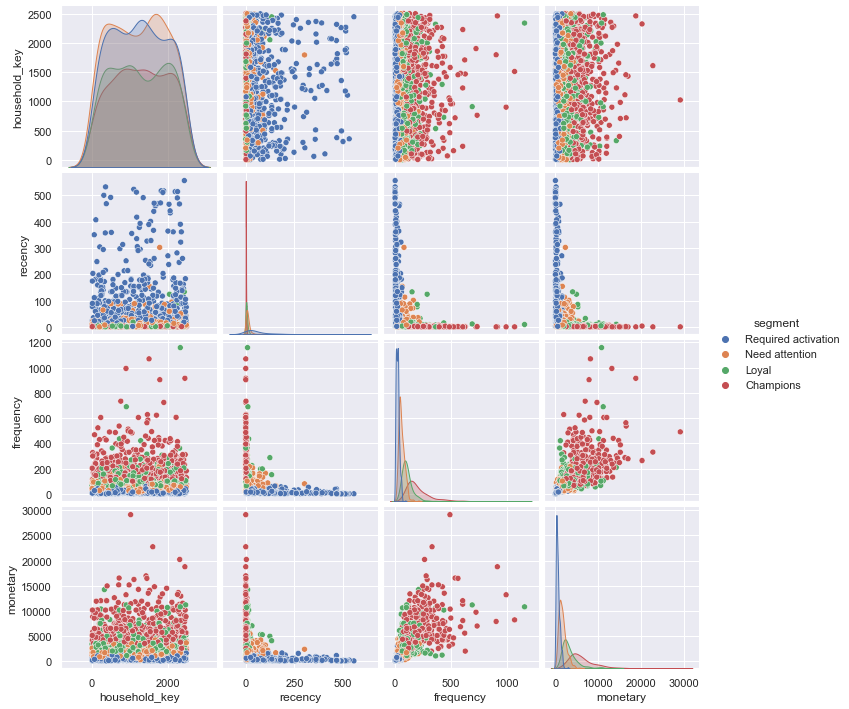

In [47]:
sns.pairplot(data=df_cus_segnment,hue='segment')

In [49]:
df_cus_segnment.groupby('segment').household_key.count()

segment
Required activation    720
Need attention         752
Loyal                  523
Champions              503
Name: household_key, dtype: int64

In [50]:

# Export households before camp18 is launched without demographic details into a new table

df_household.to_csv('DATA_CLEAN/households_withoutDemographic_beforeCamp18_02.csv',index=False)

In [53]:
# Export households before camp18 is launched with demographic details into a new table

df_household_demo = df_household.merge(df_cus_full,on='household_key')
df_household_demo.to_csv('DATA_CLEAN/households_beforeCamp18_02.csv',index=False)
df_household_demo



,household_key,received_campaign,redeemed_coupons,total_campaigns_received,TypeA,TypeB,TypeC,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend,recency,frequency,monetary,rfm_group,rfm_score,segment,campA_26_converted,campA_30_converted,campA_8_converted,campA_13_converted,campA_18_converted,campB_28_converted,campB_29_converted,campB_1_converted,campB_2_converted,campB_4_converted,campB_5_converted,campB_7_converted,campB_9_converted,campB_10_converted,campB_12_converted,campB_11_converted,campB_16_converted,campB_17_converted,campB_19_converted,campB_22_converted,campB_21_converted,campB_23_converted,campB_25_converted,campB_24_converted,campC_27_converted,campC_3_converted,campC_6_converted,campC_14_converted,campC_15_converted,campC_20_converted,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,1364,1,1,4.0,3.0,1.0,0.0,1.0,61.0,1.0,0.25,0.02,980.43,121.29,107.73,0.00,272.63,2.77,98.18,196.76,0,120,2050.37,443,11,Champions,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown
1,1130,1,0,5.0,4.0,0.0,1.0,0.0,98.0,0.0,0.00,0.00,2451.56,355.96,418.60,20.00,652.72,39.29,19.33,540.69,0,303,5150.75,444,12,Champions,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,55-64,U,25-34K,Renter,2 Adults Kids,3,1
2,98,1,0,2.0,1.0,0.0,1.0,0.0,50.0,0.0,0.00,0.00,996.03,10.69,65.59,0.00,158.05,21.12,0.00,96.90,0,112,1429.81,432,9,Loyal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,35-44,U,35-49K,Unknown,1 Adult Kids,2,1
3,1172,1,0,3.0,2.0,1.0,0.0,0.0,51.0,0.0,0.00,0.00,1812.16,38.30,210.90,0.00,677.68,27.83,46.50,92.98,0,127,3333.39,443,11,Champions,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,25-34,B,50-74K,Unknown,Single Male,1,None/Unknown
4,1060,1,0,7.0,4.0,3.0,0.0,0.0,107.0,0.0,0.00,0.00,3793.49,376.59,230.63,4.43,755.49,0.00,0.00,477.01,14,59,5986.16,224,8,Need attention,1,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,35-44,B,35-49K,Renter,2 Adults No Kids,2,None/Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,1678,1,0,3.0,2.0,1.0,0.0,0.0,43.0,0.0,0.00,0.00,1148.29,26.49,71.34,18.00,639.47,7.68,0.00,203.13,1,73,2424.57,433,10,Loyal,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45-54,U,75-99K,Unknown,Single Female,1,None/Unknown
797,353,1,1,2.0,2.0,0.0,0.0,1.0,32.0,1.0,0.50,0.03,1070.75,61.26,341.70,0.00,261.97,64.65,4.24,258.99,0,94,2560.58,433,10,Loyal,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45-54,A,150-174K,Homeowner,2 Adults No Kids,2,None/Unknown
798,732,1,0,6.0,2.0,4.0,0.0,0.0,108.0,0.0,0.00,0.00,2116.02,44.50,270.88,144.86,30.93,62.57,0.48,145.85,6,85,3092.49,333,9,Loyal,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55-64,A,75-99K,Homeowner,2 Adults Kids,4,2
799,764,1,1,1.0,1.0,0.0,0.0,3.0,16.0,3.0,3.00,0.19,792.46,43.50,173.94,249.80,364.56,107.98,0.00,122.53,3,77,2167.60,333,9,Loyal,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35-44,A,50-74K,Homeowner,2 Adults Kids,5+,3+


In [52]:
df_household_demo[df_household_demo.campA_18_converted==1]

,household_key,received_campaign,redeemed_coupons,total_campaigns_received,TypeA,TypeB,TypeC,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend,recency,frequency,monetary,rfm_group,rfm_score,segment,campA_26_converted,campA_30_converted,campA_8_converted,campA_13_converted,campA_18_converted,campB_28_converted,campB_29_converted,campB_1_converted,campB_2_converted,campB_4_converted,campB_5_converted,campB_7_converted,campB_9_converted,campB_10_converted,campB_12_converted,campB_11_converted,campB_16_converted,campB_17_converted,campB_19_converted,campB_22_converted,campB_21_converted,campB_23_converted,campB_25_converted,campB_24_converted,campC_27_converted,campC_3_converted,campC_6_converted,campC_14_converted,campC_15_converted,campC_20_converted,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
1,1130,1,0,5.0,4.0,0.0,1.0,0.0,98.0,0.0,0.00,0.00,2451.56,355.96,418.60,20.00,652.72,39.29,19.33,540.69,0,303,5150.75,444,12,Champions,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,55-64,U,25-34K,Renter,2 Adults Kids,3,1
6,718,1,1,10.0,3.0,5.0,2.0,4.0,179.0,4.0,0.40,0.02,8563.79,387.36,1067.03,995.00,1875.42,327.80,10.85,782.03,0,538,16518.81,444,12,Champions,1,1,0,1,1,0,0,0,0,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,45-54,A,25-34K,Homeowner,2 Adults Kids,5+,3+
8,2305,1,1,7.0,4.0,2.0,1.0,10.0,121.0,10.0,1.43,0.08,2459.36,28.14,692.52,85.13,1167.60,51.17,0.00,358.00,7,107,5269.78,234,9,Loyal,1,1,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown
10,2324,1,1,8.0,4.0,3.0,1.0,4.0,130.0,4.0,0.50,0.03,1085.76,98.33,101.53,37.65,384.89,35.80,0.00,79.51,4,110,1984.48,333,9,Loyal,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,35-44,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown
18,361,1,1,6.0,4.0,2.0,0.0,4.0,104.0,4.0,0.67,0.04,3622.17,298.99,546.02,0.00,738.73,10.49,4.64,1062.32,1,186,6761.63,444,12,Champions,1,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,1995,1,1,7.0,2.0,5.0,0.0,5.0,121.0,5.0,0.71,0.04,5041.22,205.60,768.68,519.21,1513.54,1218.00,32.77,418.47,4,102,10650.39,334,10,Loyal,0,0,1,1,1,0,1,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,25-34,B,25-34K,Unknown,1 Adult Kids,3,2
792,1074,1,1,3.0,2.0,1.0,0.0,3.0,45.0,3.0,1.00,0.07,3683.30,105.72,406.45,262.11,529.30,3.99,0.24,383.71,1,102,5988.07,434,11,Champions,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45-54,A,35-49K,Homeowner,2 Adults Kids,4,2
793,492,1,1,6.0,2.0,2.0,2.0,1.0,83.0,1.0,0.17,0.01,3971.05,12.98,281.91,923.07,655.84,31.22,0.00,59.76,1,107,6499.72,434,11,Champions,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,45-54,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown
794,2147,1,1,3.0,2.0,1.0,0.0,6.0,47.0,6.0,2.00,0.13,2207.69,224.31,756.85,144.34,196.24,75.87,0.00,362.18,1,68,4324.01,434,11,Champions,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25-34,A,75-99K,Homeowner,2 Adults Kids,3,1
